# 2022-01-24 Convergence classes

* Office hours: Monday 9-10pm, Tuesday 2-3pm, Thursday 2-3pm
* This week will stay virtual. Plan is to start in-person the following Monday (Jan 31)

## Last time

* Forward and backward error
* Computing volume of a polygon
* Rootfinding examples
* Use [Roots.jl](https://juliapackages.com/p/roots) to solve
* Introduce Bisection

## Today

* Discuss rootfinding as a modeling tool
* Limitations of bisection
* Convergence classes
* Intro to Newton methods

In [136]:
using Plots
default(linewidth=4)

# Stability demo: Volume of a polygon

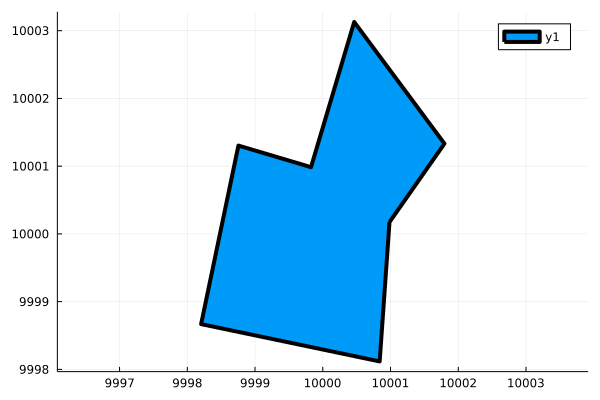

In [156]:
X = ([1 0; 2 1; 1 3; 0 1; -1 1.5; -2 -1; .5 -2; 1 0])
R(θ) = [cos(θ) -sin(θ); sin(θ) cos(θ)]
Y = X * R(deg2rad(10))' .+ [1e4 1e4]
plot(Y[:,1], Y[:,2], seriestype=:shape, aspect_ratio=:equal)

In [157]:
using LinearAlgebra
function pvolume(X)
    n = size(X, 1)
    vol = sum(det(X[i:i+1, :]) / 2 for i in 1:n-1)
end

@show pvolume(Y)
[det(Y[i:i+1, :]) for i in 1:size(Y, 1)-1]
A = Y[2:3, :]
sum([A[1,1] * A[2,2], - A[1,2] * A[2,1]])
X

pvolume(Y) = 9.249999989226126


8×2 Matrix{Float64}:
  1.0   0.0
  2.0   1.0
  1.0   3.0
  0.0   1.0
 -1.0   1.5
 -2.0  -1.0
  0.5  -2.0
  1.0   0.0

* Why don't we even get the first digit correct? These numbers are only $10^8$ and $\epsilon_{\text{machine}} \approx 10^{-16}$ so shouldn't we get about 8 digits correct?

# Rootfinding

> Given $f(x)$, find $x$ such that $f(x) = 0$.

We'll work with scalars ($f$ and $x$ are just numbers) for now, and revisit later when they vector-valued.

## Change inputs to outputs

* $f(x; b) = x^2 - b$
  * $x(b) = \sqrt{b}$
* $f(x; b) = \tan x - b$
  * $x(b) = \arctan b$
* $f(x) = \cos x + x - b$
  * $x(b) = ?$

We aren't given $f(x)$, but rather an algorithm `f(x)` that approximates it.
* Sometimes we get extra information, like `fp(x)` that approximates $f'(x)$
* If we have source code for `f(x)`, maybe it can be transformed "automatically"

# Nesting matryoshka dolls of rootfinding

* I have a function (pressure, temperature) $\mapsto$ (density, energy)
  * I need (density, energy) $\mapsto$ (pressure, temperature)
* I know what condition is satisfied across waves, but not the state on each side. 

![](../img/Toro-ShockOrRarefaction-2.19.png)

* Given a proposed state, I can measure how much (mass, momentum, energy) is not conserved.
  * Find the solution that conserves exactly
* I can compute lift given speed and angle of attack
  * How much can the plane lift?
  * How much can it lift on a short runway?
![](../img/Boeing_A2_isoQspeed2_lowRes.png)

# Discuss: rootfinding and inverse problems

* Inverse kinematics for robotics
  * (statics) how much does each joint an robotic arm need to move to grasp an object
  * (with momentum) fastest way to get there (motors and arms have finite strength)
  * similar for virtual reality
* Infer a light source (or lenses/mirrors) from an iluminated scene
* Imaging
  * radiologist seeing an x-ray is mentally inferring 3D geometry from 2D image
  * computed tomography (CT) reconstructs 3D model from multiple 2D x-ray images
  * seismology infers subsurface/deep earth structure from seismograpms



# Iterative bisection

In [158]:
f(x) = cos(x) - x
hasroot(f, a, b) = f(a) * f(b) < 0
function bisect_iter(f, a, b, tol)
    hist = Float64[]
    while abs(b - a) > tol
        mid = (a + b) / 2
        push!(hist, mid)
        if hasroot(f, a, mid)
            b = mid
        else
            a = mid
        end
    end
    hist
end

bisect_iter (generic function with 1 method)

In [159]:
length(bisect_iter(f, -1, 3, 1e-20))

56

# Let's plot the error

$$ \lvert \texttt{bisect}^k(f, a, b) - r \rvert, \quad k = 1, 2, \dotsc $$

where $r$ is the true root, $f(r) = 0$.

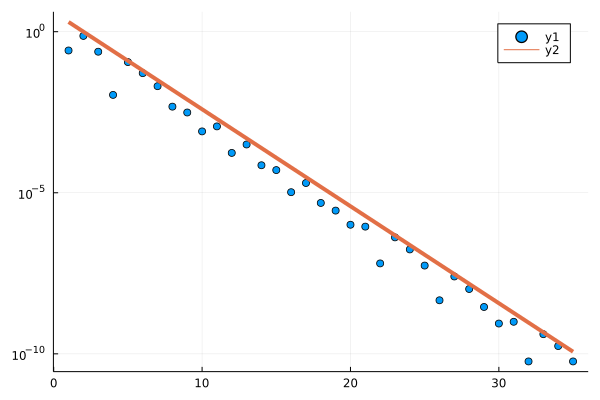

In [160]:
hist = bisect_iter(f, -1, 3, 1e-10)
r = hist[end] # What are we trusting?
hist = hist[1:end-1]
scatter( abs.(hist .- r), yscale=:log10)
ks = 1:length(hist)
plot!(ks, 4 * (.5 .^ ks))

Evidently the error $e_k = x_k - x_*$ after $k$ bisections satisfies the bound
$$ |e^k| \le c 2^{-k} . $$

# Convergence classes

A convergent rootfinding algorithm produces a sequence of approximations $x_k$ such that $$\lim_{k \to \infty} x_k \to x_*$$ where $f(x_*) = 0$.  For analysis, it is convenient to define the errors $e_k = x_k - x_*$. We say that an iterative algorithm is **$q$-linearly convergent** if $$\lim_{k \to \infty} |e_{k+1}| / |e_k| = \rho < 1.$$  (The $q$ is for "quotient".)  A smaller convergence factor $\rho$ represents faster convergence.  A slightly weaker condition ($r$-linear convergence or just **linear convergence**) is that
$$ |e_k| \le \epsilon_k $$
for all sufficiently large $k$ when the sequence $\{\epsilon_k\}$ converges $q$-linearly to 0.

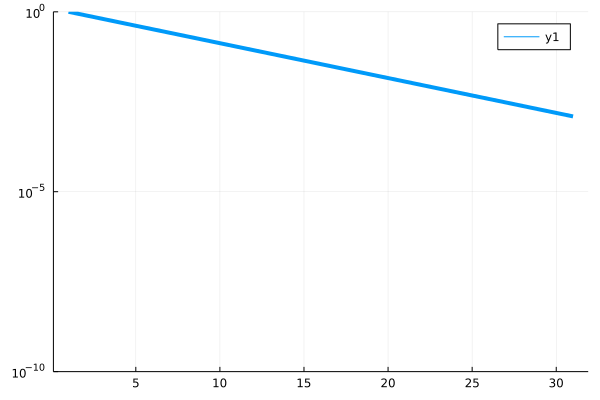

In [121]:
ρ = 0.8
errors = [1.]
for i in 1:30
    next_e = errors[end] * ρ
    push!(errors, next_e)
end
plot(errors, yscale=:log10, ylims=(1e-10, 1))

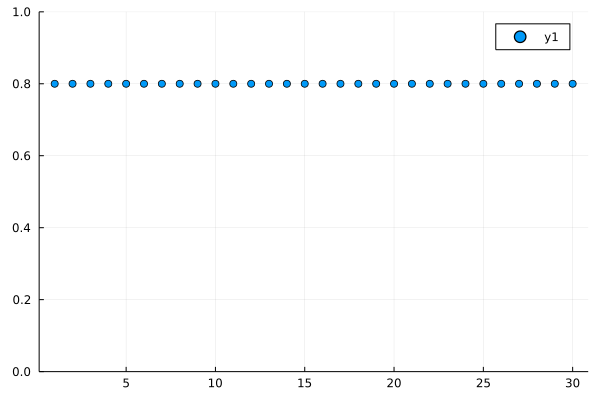

In [125]:
e = hist .- r
scatter(abs.(errors[2:end] ./ errors[1:end-1]), ylims=(0,1))

## Bisection: A = q-linearly convergent, B = r-linearly convergent, C = neither

# Remarks on bisection

* Specifying an interval is often inconvenient
* An interval in which the function changes sign guarantees convergence (robustness)
* No derivative information is required
* If bisection works for $f(x)$, then it works and gives the same accuracy for $f(x) \sigma(x)$ where $\sigma(x) > 0$.
* Roots of even degree are problematic
* A bound on the solution error is directly available
* The convergence rate is modest -- one iteration per bit of accuracy

# Newton-Raphson Method

Much of numerical analysis reduces to [Taylor series](https://en.wikipedia.org/wiki/Taylor_series), the approximation
$$ f(x) = f(x_0) + f'(x_0) (x-x_0) + f''(x_0) (x - x_0)^2 / 2 + \underbrace{\dotsb}_{O((x-x_0)^3)} $$
centered on some reference point $x_0$.

In numerical computation, it is exceedingly rare to look beyond the first-order approximation
$$ \tilde f_{x_0}(x) = f(x_0) + f'(x_0)(x - x_0) . $$
Since $\tilde f_{x_0}(x)$ is a linear function, we can explicitly compute the unique solution of $\tilde f_{x_0}(x) = 0$ as
$$ x = x_0 - f(x_0) / f'(x_0) . $$
This is Newton's Method (aka Newton-Raphson or Newton-Raphson-Simpson) for finding the roots of differentiable functions.

# An implementation

In [126]:
function newton(f, fp, x0; tol=1e-8, verbose=false)
    x = x0
    for k in 1:100 # max number of iterations
        fx = f(x)
        fpx = fp(x)
        if verbose
            println("[$k] x=$x  f(x)=$fx  f'(x)=$fpx")
        end
        if abs(fx) < tol
            return x, fx, k
        end
        x = x - fx / fpx
    end  
end

f(x) = cos(x) - x
fp(x) = -sin(x) - 1
newton(f, fp, 1; tol=1e-15, verbose=true)

[1] x=1  f(x)=-0.45969769413186023  f'(x)=-1.8414709848078965
[2] x=0.7503638678402439  f(x)=-0.018923073822117442  f'(x)=-1.6819049529414878
[3] x=0.7391128909113617  f(x)=-4.6455898990771516e-5  f'(x)=-1.6736325442243012
[4] x=0.739085133385284  f(x)=-2.847205804457076e-10  f'(x)=-1.6736120293089505
[5] x=0.7390851332151607  f(x)=0.0  f'(x)=-1.6736120291832148


(0.7390851332151607, 0.0, 5)